## Brief description of the notebook

In This notebook ,we aim for semi supervised ML algorithms for AD within our saas dataset.
 the dataset saas is the output of our previous processing and aggregation of features (notebook SaasV1Visualization&Generation)
For threshold definition we rely on chebyshev inequality
For validation, we use the chebyshev inequality threshold to build the ground truth, we use it along with confusion matrix and ROC-AUC to assess performance.

 
For Anomaly detection we rely on tools from PYOD Library ,which is a comprehensive and scalable Python toolkit for detecting outlying objects in multivariate data. for further reading https://pyod.readthedocs.io/en/latest/

for our case,We chose to apply two commonly used algorithms for AD:
    
     ISOLATION FOREST
         The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting
         a split value between the maximum and minimum values of the selected feature. 
     KNN
        kNN class for outlier detection. For an observation, its distance to its kth nearest neighbor could be
        viewed as the outlying score. It could be viewed as a way to measure the density. 
        
     LOF
         LOF Wrapper of scikit-learn LOF Class with more functionalities. 
         Unsupervised Outlier Detection using Local Outlier Factor (LOF).
    The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.
    
     OCSVM
         Wrapper of scikit-learn one-class SVM Class with more functionalities. Unsupervised Outlier Detection.
    Estimate the support of a high-dimensional distribution.
     
     COF
         Connectivity-Based Outlier Factor (COF) COF uses the ratio of average chaining distance of data point and 
         the average of average chaining distance of k nearest neighbor of the data point, as the outlier score for observations.

In [1]:

import pandas as pd  # manipulation et l'analyse des données
import numpy as np   #numpy pour manipuler les tableaux et faire des operations scientifiques

import matplotlib # pour  tracer et visualiser des données sous formes de graphiques
import matplotlib.pyplot as plt
import seaborn as sns # tracer et visualiser des données sous des formats avancées (statistique par exemple)

#Scipy : bibliotheque scientifique sous python
from scipy.stats import norm
from scipy.stats import kstest, norm #pour etudier la normalité des données
import scikitplot as skplt #outil de visualisation

#apprentissage:
#sklearn bibliotheque destinée à l'apprentissage automatique.
from sklearn.model_selection import train_test_split

#pyod :bibliotheque python dediée a la detection d'anomalie
from pyod.models.iforest import IForest #Isolation Forest
from pyod.models.knn import KNN     #K-Nearest-Neighbour
from pyod.models.lof import LOF    #Local Outlier Factor
from pyod.models.ocsvm import OCSVM  # One class SVM
from pyod.models.cof import COF       #Connectivity-based Outlier Factor

#Evaluation:
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
    classification_report, confusion_matrix
from pyod.utils.data import evaluate_print



In [2]:
%matplotlib inline
np.random.seed = 0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000253DED9E548>]],
      dtype=object)

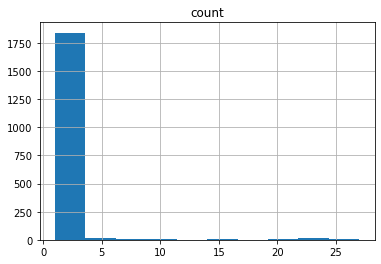

In [3]:
df_saas =pd.read_csv("saas.csv",parse_dates=['timestamp'] ,
                       index_col=['timestamp'])#comment if timestamp indexing not wanted
df_sas = df_saas[['count']]
df_sas.hist()



In [4]:
df_saas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1904 entries, 2019-06-06 09:43:21 to 2020-06-25 20:56:55
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     1904 non-null   int64  
 1   event_type  1904 non-null   object 
 2   cl_0        1904 non-null   int64  
 3   cl_1        1904 non-null   int64  
 4   cl_2        1904 non-null   float64
 5   cl_3        1904 non-null   float64
 6   cl_4        1904 non-null   float64
 7   cl_5        1904 non-null   float64
 8   cl_6        1904 non-null   float64
 9   cl_7        1904 non-null   float64
 10  cl_8        1904 non-null   float64
 11  cl_9        1904 non-null   float64
 12  cl_10       1904 non-null   float64
 13  cl_11       1904 non-null   float64
 14  cl_12       1904 non-null   float64
 15  cl_13       1904 non-null   float64
 16  cl_14       1904 non-null   float64
 17  cl_15       1904 non-null   float64
 18  cl_16       1904 non-null   floa

## SaaS Data normality, chebyshev rule and threshold

In [5]:
print("SaaS data normality test")
ks_statistic, p_value = kstest(df_sas, 'norm')
print("ks_statistic " ,ks_statistic)
print("p_value " ,p_value)

SaaS data normality test
ks_statistic  1.0
p_value  0.0


    The Test Statistic of the KS Test is the Kolmogorov Smirnov Statistic, which follows a 
    Kolmogorov distribution if the null hypothesis is true.

    If the observed data perfectly follow a normal distribution, the value of the KS statistic will be 0.
    The P-Value is used to decide whether the difference is large enough to reject the null hypothesis

    If the P-Value of the KS Test is larger than 0.05, we assume a normal distribution
    If the P-Value of the KS Test is smaller than 0.05, we do not assume a normal distribution

## “Chebyshev Bound”.

In [6]:
def find_anomalies(random_data):
    sigma = np.std(random_data)
    mu = np.mean(random_data)
    print('DATA MEAN :')
    print(mu)
    print('  STD : ')
    print(sigma)
    
    # Set upper and lower limit to 2 standard deviation
    print("")
    print('upper  value')
    upper_limit = mu+ (2*sigma)
    print(upper_limit)
    print('lower value')
    lower_limit = mu- (2*sigma)
    print(lower_limit)
    
    # Find outliers
    anomalies = []
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return upper_limit,anomalies

In [7]:
lim , anom = find_anomalies(df_sas['count'] )


DATA MEAN :
1.986344537815126
  STD : 
2.9255148363602306

upper  value
7.837374210535588
lower value
-3.864685134905335


In [8]:
print("---------------------------------------------")
print("")
print(' Events outside of the upper limit per user_id+clients per seconds-min-hour-day-month:  ')
evt_anom = df_sas[ df_sas['count'] > lim ]
evt_anom

#uncomment for further details about the data>threshold
#evt_anom =  df_saas[  df_saas['count'] > lim ]
#evt_anom

---------------------------------------------

 Events outside of the upper limit per user_id+clients per seconds-min-hour-day-month:  


,count
timestamp,
2019-06-30 20:02:15,22
2019-06-30 20:02:16,23
2019-06-30 20:02:17,22
2019-06-30 20:02:18,22
2019-06-30 20:02:19,20
2019-07-02 20:02:10,17
2019-07-02 20:02:11,11
2019-07-02 20:02:12,21
2019-07-02 20:02:13,24


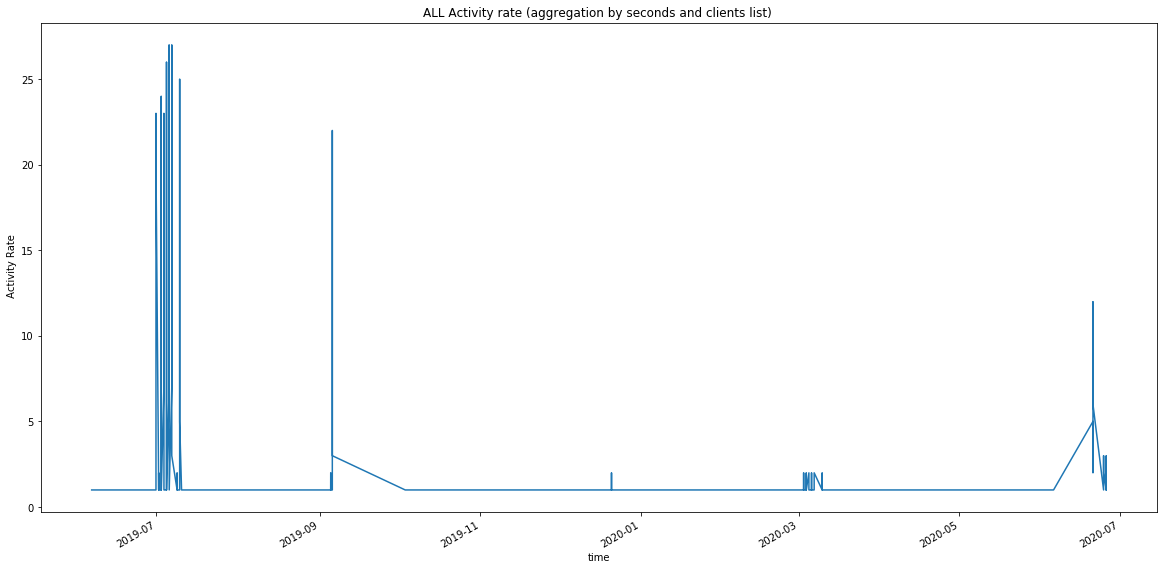

In [9]:

#plotting the count graphic/ figure 
df_sas['count'].plot(#kind='line',
             figsize=(20, 10), # pass a tuple (x, y) size
             )

plt.title('ALL Activity rate (aggregation by seconds and clients list) ')
plt.ylabel(' Activity Rate')
plt.xlabel('time')

plt.show() 

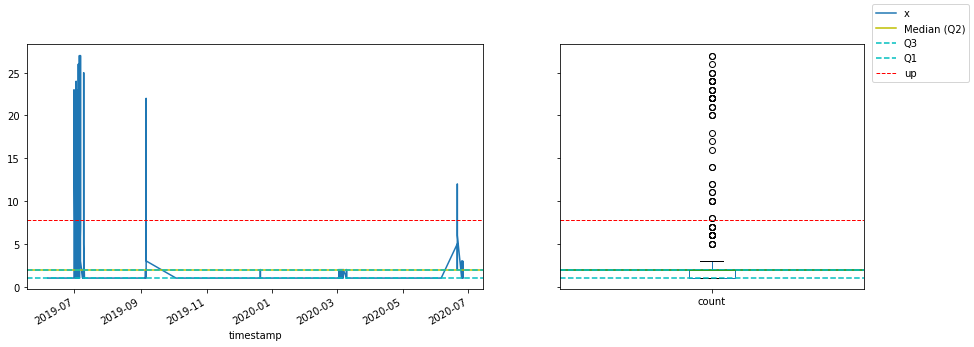

In [10]:
x = df_sas['count'] # we take our count vectors into an array

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True, gridspec_kw={'width_ratios': [3,  2]})
# time plot with median Q1 and Q3 displayed

x.plot(ax=axes[0], label='x')
axes[0].axhline(x.median(), color='y', label='Median (Q2)')
axes[0].axhline(x.quantile(0.25), color='c', linestyle='--', label='Q3')
axes[0].axhline(x.quantile(0.75), color='c', linestyle='--', label='Q1')
axes[0].axhline(lim, color='r', linestyle='--', linewidth=1, label='up')
#axes[0].axhline(down_limit, color='r', linestyle='--', linewidth=1, label='down')
 

# boxplot
x.plot.box(ax=axes[1])
axes[1].axhline(x.median(), color='g')
axes[1].axhline(x.quantile(0.25), color='c', linestyle='--')
axes[1].axhline(x.quantile(0.75), color='c', linestyle='--')
axes[1].axhline(lim, color='r', linestyle='--', linewidth=1)
fig.legend();

le 1er quartile est la donnée de la série qui sépare les 25 % inférieurs des données (notation Q1) ;
le 2e quartile est la donnée de la série qui sépare les 50 % inférieurs des données (notation Q2) ; il est également appelé médiane ;
le 3e quartile est la donnée de la série qui sépare les 75 % inférieurs des données (notation Q3) 

La différence entre le troisième quartile et le premier quartile s'appelle écart interquartile ;
 c'est un critère de dispersion de la série. 


# ML Anomaly Detection
##  Preparing data for outliers detection

In [11]:
df_sas.info() #checking infos

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1904 entries, 2019-06-06 09:43:21 to 2020-06-25 20:56:55
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   1904 non-null   int64
dtypes: int64(1)
memory usage: 29.8 KB


### building the ground Truth
In order to build the ground truth, we rely on chebyshev rule to separate abnormal activity rates that are above the limit from the normal levels.

In [12]:
df_sas.head()
df_sas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1904 entries, 2019-06-06 09:43:21 to 2020-06-25 20:56:55
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   1904 non-null   int64
dtypes: int64(1)
memory usage: 29.8 KB


In [13]:
x = df_sas['count']
is_outlier = (x > lim) #outliers are the values that > limit defined by chebyshev's inequality rule

df_sas = pd.concat([x, is_outlier], axis=1, keys=['x', 'is_outlier'])#we add the "labels" to our dataframe 
df_sas['is_outlier'].value_counts()

False    1859
True       45
Name: is_outlier, dtype: int64

In [14]:
df_sas

,x,is_outlier
timestamp,,
2019-06-06 09:43:21,1,False
2019-06-24 06:29:17,1,False
2019-06-24 20:02:12,1,False
2019-06-24 20:46:40,1,False
2019-06-25 20:02:09,1,False
...,...,...
2020-06-25 20:56:51,3,False
2020-06-25 20:56:52,2,False
2020-06-25 20:56:53,2,False


In [15]:
print(f'Number of theoretical outliers: {len(df_sas[df_sas.is_outlier])}')
print(f'Number of theoretical  inliers: {len(df_sas[~df_sas.is_outlier])}') 
print(f'Percentage of outliers (contamination): {len(df_sas[df_sas.is_outlier]) * 1. / len(df_sas)}') 

Number of theoretical outliers: 45
Number of theoretical  inliers: 1859
Percentage of outliers (contamination): 0.023634453781512604


In [16]:
#defining our y variable ,which we gonna use later for validation aka ground truth
y_true=df_sas.is_outlier.astype(int)#we convert the "labels" from boolean True/False to 1/0 (numeric)
y =  y_true.copy()


### Data normalisation

In [17]:
df = pd.read_csv('saas.csv')

In [18]:
df.head()
df.shape

(1904, 24)

In [19]:
X = df['count']#get the count values in an array

# formating data for the algorithm (should be a 2D numpy array, see sklearn API)
X=x.values.reshape(-1, 1)

#When you do unsupervised learning, it is always a safe step to standardize the predictors
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)


In [20]:
X #our new values are between -1 and 1

array([[-0.33715246],
       [-0.33715246],
       [-0.33715246],
       ...,
       [ 0.00466771],
       [ 0.34648789],
       [-0.33715246]])

### Splitting train test set

In [21]:
# Split the dataset in two parts
#train set 70% of data
#test set 30% of data
#here, we are still in an unsupervised learning, we only add the ground truth (y_true) to the split_train_test so that
#we get correspond y_train and y_test to evaluate our train set x_train and testset x_test
X_train, X_test ,y_train ,y_test = train_test_split(X,y_true, test_size=0.3, random_state=42)

print('X_train: ' , X_train.shape )
print('X_test : ' , X_test.shape)


#print('y_train: ' , y_train.shape )
#print('y_test : ' , y_test.shape)

X_train:  (1332, 1)
X_test :  (572, 1)


In [22]:
l_test = X_test.size
l_train = X_train.size

In [23]:
df_test_plot = df_sas.tail(l_test)
# this dataframe will be used for saving the results of each ML model performed on test data

In [24]:
y_val =y_test.astype(int) 

# ISOLATION FOREST PYOD VERSION

https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest

In [25]:
# creating the outlier detector
clf_iforest = IForest(
    behaviour='new',
    random_state=47,
    n_estimators=100,#, # the number of base estimators
    #max_samples=0.8, #number of samples to draw from X to train each base estimator
    contamination=0.01, #proportion of outliers in the data set -->threshold to decision function
   # max_features=1.0 
    )

In [26]:
# "fitting" the detector 
clf_iforest.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=47, verbose=0)

In [27]:
clf_iforest

IForest(behaviour='new', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=47, verbose=0)

I apply the trained model *clf_iforest* to predict the anomaly score for each observation in the test data.
How do we define an outlier? An outlier is a point that is distant from other points, so the outlier score is defined by distance. 
The PyOD function .decision_function() calculates the distance or the anomaly score for each data point.


In [28]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores = clf_iforest.decision_function(X_test )  # outlier scores
y_test_scores = pd.Series(y_test_scores)


In [29]:
y_test_scores

0     -0.332515
1     -0.332515
2     -0.332515
3     -0.332515
4     -0.354012
         ...   
567   -0.332515
568   -0.354012
569   -0.332515
570   -0.354012
571   -0.332515
Length: 572, dtype: float64

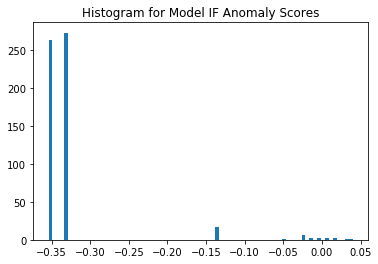

In [30]:
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model IF Anomaly Scores")
plt.show()

    in the X axis, the histogram shows the “score” values whoch are the average distance of those observations to others. 
    A high “score” means that observation is far away from the norm.
    high scores tend to be at low frequency, which validates the assumption of outlier presence
    in the Y axis, the number of corresponding obsrvations/entrees



## Visualizing the "outlierness" score computed by the isolation forest algorithm

### On the TRAIN DATA

In [31]:
df_train_plot = df_sas.head(l_train) #this dataframe is for saving th results of Ml model performed on trainset


In [32]:
%%time
df_train_plot['isolation_forest_score'] = clf_iforest.decision_function(X_train)#calculate score of observations on trainset
df_train_plot['isolation_forest_outliers'] = clf_iforest.predict(X_train)#decide for observations based on their scores whether they are outliers or inliers

df_train_plot

Wall time: 101 ms


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,x,is_outlier,isolation_forest_score,isolation_forest_outliers
timestamp,,,,
2019-06-06 09:43:21,1,False,-0.354012,0
2019-06-24 06:29:17,1,False,-0.332515,0
2019-06-24 20:02:12,1,False,-0.354012,0
2019-06-24 20:46:40,1,False,-0.332515,0
2019-06-25 20:02:09,1,False,-0.332515,0
...,...,...,...,...
2020-03-05 21:49:47,1,False,-0.354012,0
2020-03-05 21:49:48,2,False,-0.332515,0
2020-03-05 21:49:49,2,False,-0.332515,0


In [33]:
df_train_plot['x'].value_counts()

1     815
2     466
22      8
24      6
7       5
23      4
10      3
25      3
21      3
20      3
3       2
6       2
27      2
11      2
14      2
8       1
26      1
5       1
17      1
18      1
16      1
Name: x, dtype: int64

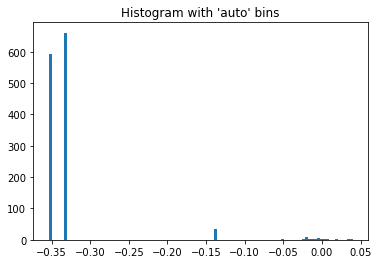

In [34]:
# Plot hist
import matplotlib.pyplot as plt
plt.hist(df_train_plot['isolation_forest_score'], bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

in the X axis, the histogram shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
high scores tend to be at low frequency, which validates the assumption of outlier presence
in the Y axis, the number of corresponding obsrvations/entrees

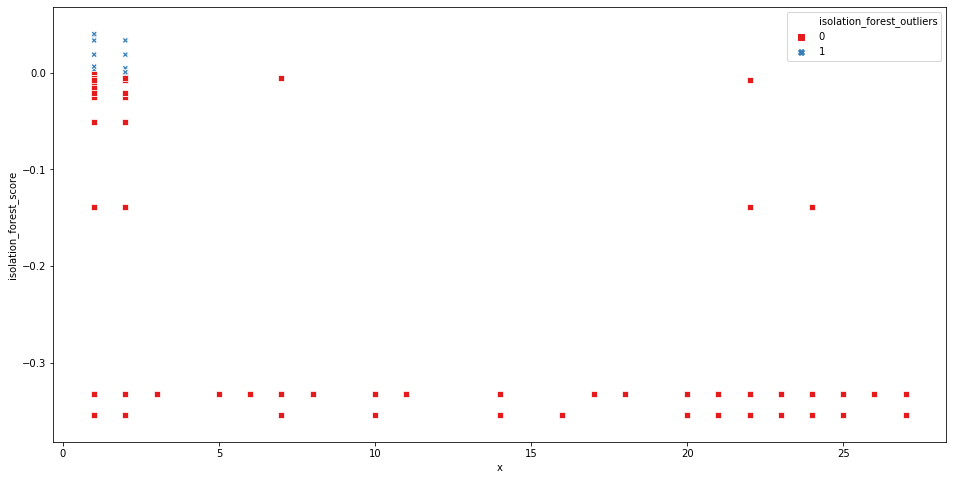

In [35]:
#scatterplot the obtained results on the trainset
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_train_plot, 
    x='x', 
    y='isolation_forest_score', 
    #hue='is_outlier',
    hue='isolation_forest_outliers',

    palette="Set1",
    sizes=(40, 200), #hue_norm=(0, 9),
    style='isolation_forest_outliers',
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values whoch are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

### on the TEST DATA

In [36]:
%%time

df_test_plot['isolation_forest_score'] = clf_iforest.decision_function(X_test)#calculate score for each observation in testset
df_test_plot['isolation_forest_outliers'] = clf_iforest.predict(X_test)# decide for calculated scores if an observation is an outlier or inlier

df_test_plot

Wall time: 78 ms


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,x,is_outlier,isolation_forest_score,isolation_forest_outliers
timestamp,,,,
2020-03-05 21:49:52,2,False,-0.332515,0
2020-03-05 21:49:53,2,False,-0.332515,0
2020-03-05 21:49:54,2,False,-0.332515,0
2020-03-05 21:49:55,2,False,-0.332515,0
2020-03-05 21:49:56,2,False,-0.354012,0
...,...,...,...,...
2020-06-25 20:56:51,3,False,-0.332515,0
2020-06-25 20:56:52,2,False,-0.354012,0
2020-06-25 20:56:53,2,False,-0.332515,0


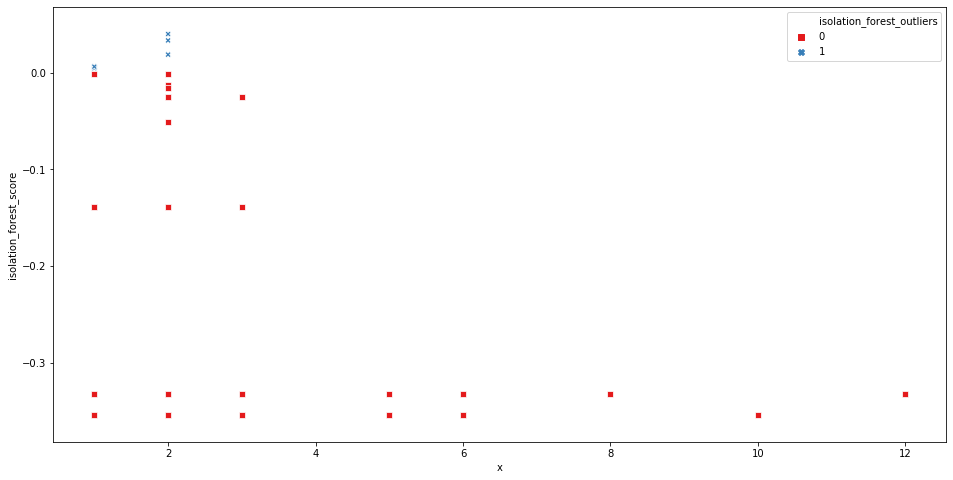

In [37]:
#plot the resuls on testset
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='isolation_forest_score', 
     #hue='is_outlier',
    hue='isolation_forest_outliers',

    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    style='isolation_forest_outliers',
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

#### Plot IF results on Test set with Ground Truth labels

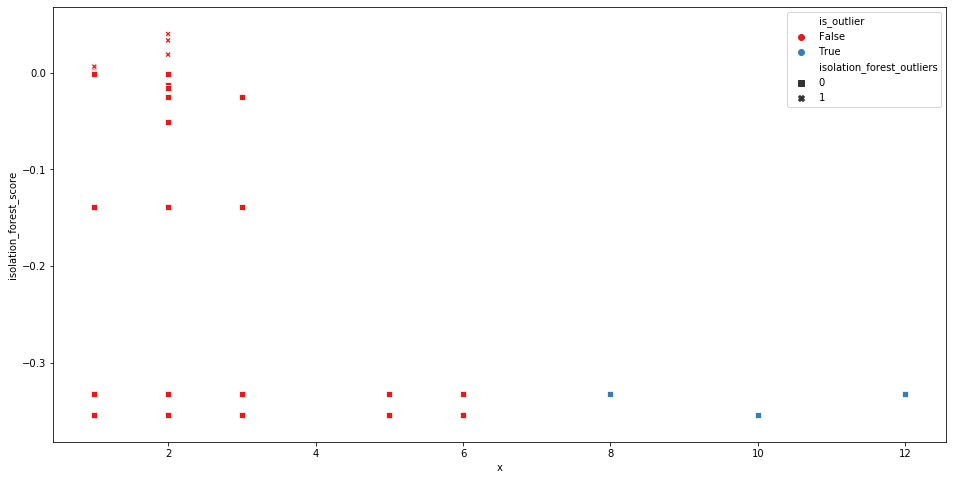

In [38]:
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='isolation_forest_score', 
    hue='is_outlier',

    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    style='isolation_forest_outliers',
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values whoch are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.



## Evaluating isolation forest algorithm


In [39]:
clf_name = 'Isolation Forest'
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, df_train_plot.isolation_forest_outliers)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, df_test_plot.isolation_forest_outliers)


On Training Data:
Isolation Forest ROC:0.7, precision @ rank n:1.0

On Test Data:
Isolation Forest ROC:0.85, precision @ rank n:1.0


In [40]:


y_pred=df_test_plot.isolation_forest_outliers

#The F1 score: weighted average of the precision and recall, 
  #  where an F1 score reaches its best value at 1 and worst score at 0. 
  #  The relative contribution of precision and recall to the F1 score are equal.
    #F1 = 2 * (precision * recall) / (precision + recall)
print('f1_score ', f1_score(y_val
                            , y_pred, average="macro"))


#The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
#fp the number of false positives.
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print('precision_score ',precision_score(y_val, y_pred, average="macro"))


#The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number 
#of false negatives.
#The recall is intuitively the ability of the classifier to find all the positive samples.
print('recall_score ',recall_score(y_val, y_pred, average="macro"))

f1_score  0.9104337387128765
precision_score  0.9973451327433629
recall_score  0.85


In [41]:


confusion_matrix(y_val, y_pred=df_test_plot.isolation_forest_outliers )



array([[562,   0],
       [  3,   7]], dtype=int64)

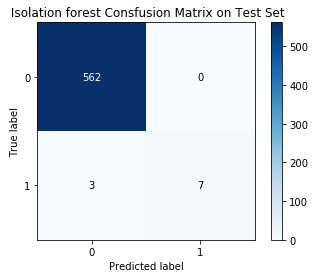

In [42]:


# plot the comfusion matrix  in the test set
y_preds = clf_iforest.predict(X_test)


skplt.metrics.plot_confusion_matrix(y_test,y_preds, normalize=False,
                                    title=" Isolation forest Consfusion Matrix on Test Set")
plt.show()

# K Nearest Neighbors
    https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn


In [43]:
clf_knn = KNN(
    contamination=0.01,
    n_neighbors=5,
    method='median',
    algorithm= 'ball_tree',
    #leaf_size=30,
    metric='minkowski'
)


In [44]:
%%time

clf_knn.fit(X_train) #fit the model

#train visualization
df_train_plot['KNN_score'] = clf_knn.decision_function(X_train)#calculate the scores on trainset observations
df_train_plot['KNN_outliers'] = clf_knn.predict(X_train)#decide for the calculated scores whether an observation is an outlier or not


Wall time: 297 ms


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [45]:

df_train_plot


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers
timestamp,,,,,,
2019-06-06 09:43:21,1,False,-0.354012,0,0.0,0
2019-06-24 06:29:17,1,False,-0.332515,0,0.0,0
2019-06-24 20:02:12,1,False,-0.354012,0,0.0,0
2019-06-24 20:46:40,1,False,-0.332515,0,0.0,0
2019-06-25 20:02:09,1,False,-0.332515,0,0.0,0
...,...,...,...,...,...,...
2020-03-05 21:49:47,1,False,-0.354012,0,0.0,0
2020-03-05 21:49:48,2,False,-0.332515,0,0.0,0
2020-03-05 21:49:49,2,False,-0.332515,0,0.0,0


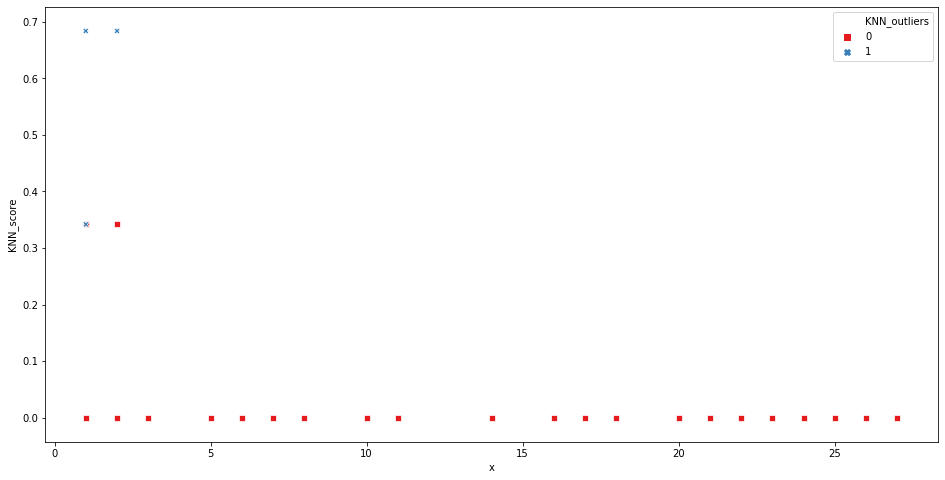

In [46]:
#scatterplot the results on trainset
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_train_plot, 
    x='x', 
    y='KNN_score', 
    #hue='is_outlier',
    hue='KNN_outliers',
    style='KNN_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values whoch are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

In [47]:
%%time
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
#y_test_scores = clf_knn.decision_function(X_test )  # outlier scores in the testset
#y_test_scores = pd.Series(y_test_scores)

# get the prediction on the test data

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.

df_test_plot['KNN_score'] = clf_knn.decision_function(X_test)
df_test_plot['KNN_outliers'] = clf_knn.predict(X_test)

df_test_plot

Wall time: 138 ms


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers
timestamp,,,,,,
2020-03-05 21:49:52,2,False,-0.332515,0,0.0,0
2020-03-05 21:49:53,2,False,-0.332515,0,0.0,0
2020-03-05 21:49:54,2,False,-0.332515,0,0.0,0
2020-03-05 21:49:55,2,False,-0.332515,0,0.0,0
2020-03-05 21:49:56,2,False,-0.354012,0,0.0,0
...,...,...,...,...,...,...
2020-06-25 20:56:51,3,False,-0.332515,0,0.0,0
2020-06-25 20:56:52,2,False,-0.354012,0,0.0,0
2020-06-25 20:56:53,2,False,-0.332515,0,0.0,0


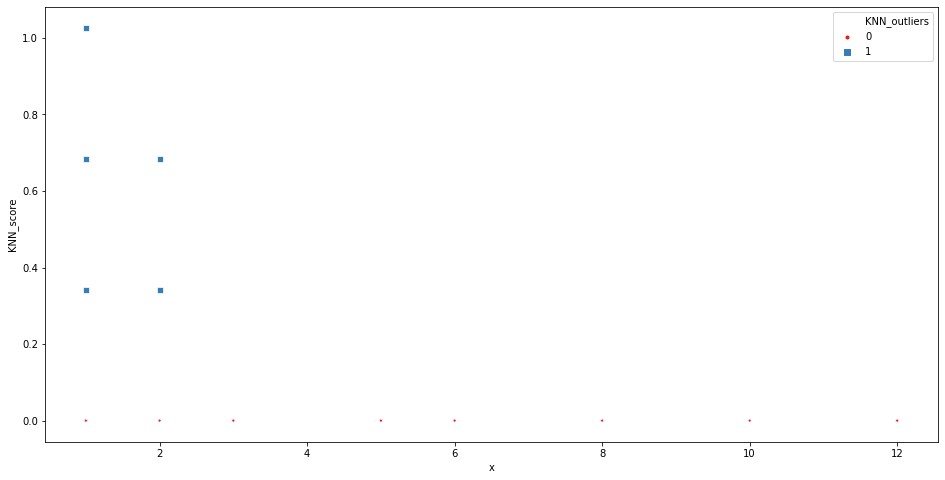

In [48]:
#test  visualization

fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='KNN_score',
    #hue='is_outlier',
    hue='KNN_outliers',
    style='KNN_outliers',
    palette="Set1",
    #hue='is_outlier',
    markers={0:'.',1:'s'},
    ax=ax
)

in the Y axis, the plot shows the “score” values whoch are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

#### test  visualization avec GroundTruth Labels


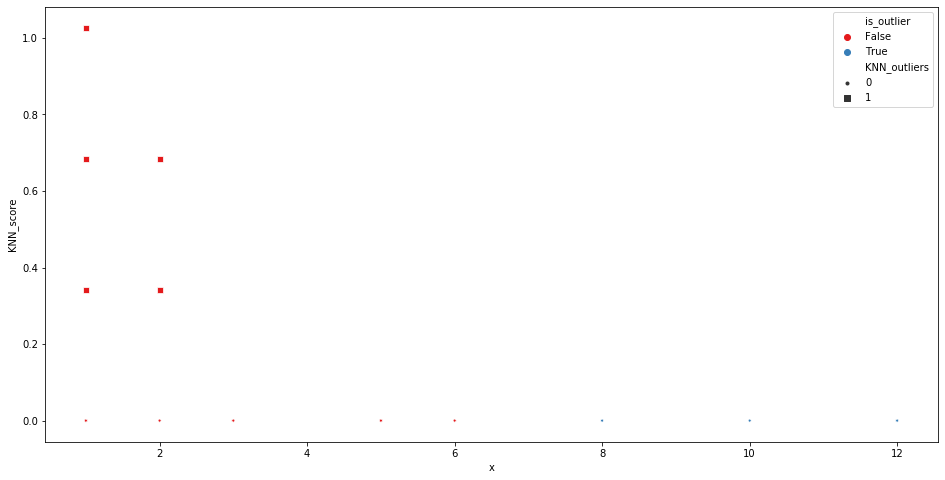

In [49]:
#test  visualization

fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='KNN_score', 
    hue='is_outlier',
    style='KNN_outliers',
    palette="Set1",
    markers={0:'.',1:'s'},
    ax=ax
)

In [50]:


confusion_matrix(y_val, y_pred=df_test_plot.KNN_outliers )

y_pred=df_test_plot.KNN_outliers

#The F1 score: weighted average of the precision and recall, 
  #  where an F1 score reaches its best value at 1 and worst score at 0. 
  #  The relative contribution of precision and recall to the F1 score are equal.
    #F1 = 2 * (precision * recall) / (precision + recall)
print('f1_score ', f1_score(y_val, y_pred, average="macro"))


#The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
#fp the number of false positives.
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print('precision_score ',precision_score(y_val, y_pred, average="macro"))


#The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number 
#of false negatives.
#The recall is intuitively the ability of the classifier to find all the positive samples.
print('recall_score ',recall_score(y_val, y_pred, average="macro"))

f1_score  0.8732269503546098
precision_score  0.9964664310954063
recall_score  0.8


After training our KNN Detector model, we can get the prediction labels on the training data and then get the outlier scores of the training data. The higher the scores are, the more abnormal. This indicates the overall abnormality in the data. These features make PyOD a great utility for anomaly detection tasks.


In [51]:
# Get the prediction labels of the training data 
y_train_pred = clf_knn.predict(X_train) # binary labels (0: inliers, 1: outliers) # Outlier scores 
y_train_scores = clf_knn.decision_function(X_train)


We can evaluate KNN() with respect to the training data. PyOD provides a handy function for this task called evaluate_print(). The default metrics include ROC and Precision @ n. We will pass class name, y_train values and y_train_scores(outlier scores as returned by a fitted model.)


In [52]:
# Evaluate on the training data e
evaluate_print('‘KNN’', y_train, y_train_scores)

‘KNN’ ROC:0.7, precision @ rank n:1.0



KNN ROC: 0.9955, precision @ rank n:0 0.6667.

We see that the KNN() model has a good performance on the training data. 
Let’s plot the confusion matrix for the train set.


We will use decision_function to predict anomaly scores of the test set using the 
fitted detector(KNN Detector) and evaluate the results.


In [53]:

y_test_scores = clf_knn.decision_function(X_test)  # outlier scores

# Evaluate on the training data
evaluate_print('KNN', y_test,y_test_scores)
#KNN ROC:0.9393, precision @ rank n:0.5408


KNN ROC:0.85, precision @ rank n:1.0


In [54]:


confusion_matrix(y_val, y_pred=df_test_plot.KNN_outliers )

array([[562,   0],
       [  4,   6]], dtype=int64)

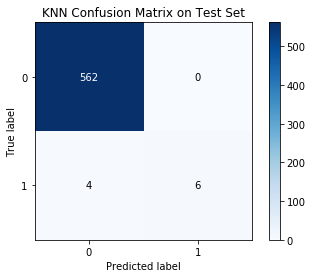

In [55]:
#Our KNN() model continues to perform well on the test set. Let’s plot the confusion matrix for the test set.

# plot the comfusion matrix  in the test set
y_preds = clf_knn.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_val,y_preds, normalize=False,
                                    title="KNN Confusion Matrix on Test Set")
plt.show()

## LOF


In [56]:
clf_lof = LOF(
    algorithm='auto',
    n_neighbors=30 ,
    contamination=0.1,
    metric='minkowski',
    n_jobs=1)


                  

In [57]:
clf_lof

LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=30, p=2)

In [58]:
%%time
clf_lof.fit(X_train)#Adjust the model to trainset

#train visualization
df_train_plot['LOF_score'] = clf_lof.decision_function(X_train)#calculate score
df_train_plot['LOF_outliers'] = clf_lof.predict(X_train)#decide for the calculated scores if an observation is an outlier or inlier

df_train_plot


Wall time: 35 ms


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers,LOF_score,LOF_outliers
timestamp,,,,,,,,
2019-06-06 09:43:21,1,False,-0.354012,0,0.0,0,1.0,0
2019-06-24 06:29:17,1,False,-0.332515,0,0.0,0,1.0,0
2019-06-24 20:02:12,1,False,-0.354012,0,0.0,0,1.0,0
2019-06-24 20:46:40,1,False,-0.332515,0,0.0,0,1.0,0
2019-06-25 20:02:09,1,False,-0.332515,0,0.0,0,1.0,0
...,...,...,...,...,...,...,...,...
2020-03-05 21:49:47,1,False,-0.354012,0,0.0,0,1.0,0
2020-03-05 21:49:48,2,False,-0.332515,0,0.0,0,1.0,0
2020-03-05 21:49:49,2,False,-0.332515,0,0.0,0,1.0,0


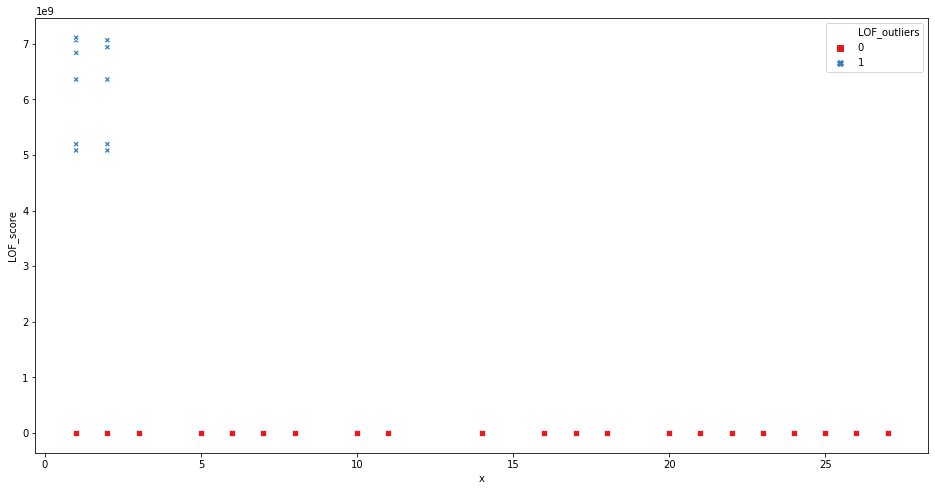

In [59]:
#scatterplot the results
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_train_plot, 
    x='x', 
    y='LOF_score', 
    #hue='is_outlier',
    hue='LOF_outliers',
    style='LOF_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values whoch are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

In [60]:
# get the prediction on the test data

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores =  clf_lof.decision_function(X_test )  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_pred =  clf_lof.predict(X_test)



df_test_plot['LOF_score'] =  clf_lof.decision_function(X_test ) 
df_test_plot['LOF_outliers'] = clf_lof.predict(X_test)

df_test_plot

#df_test_plot['LOF_outliers'].value_counts()

C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers,LOF_score,LOF_outliers
timestamp,,,,,,,,
2020-03-05 21:49:52,2,False,-0.332515,0,0.0,0,1.0,0
2020-03-05 21:49:53,2,False,-0.332515,0,0.0,0,1.0,0
2020-03-05 21:49:54,2,False,-0.332515,0,0.0,0,1.0,0
2020-03-05 21:49:55,2,False,-0.332515,0,0.0,0,1.0,0
2020-03-05 21:49:56,2,False,-0.354012,0,0.0,0,1.0,0
...,...,...,...,...,...,...,...,...
2020-06-25 20:56:51,3,False,-0.332515,0,0.0,0,1.0,0
2020-06-25 20:56:52,2,False,-0.354012,0,0.0,0,1.0,0
2020-06-25 20:56:53,2,False,-0.332515,0,0.0,0,1.0,0


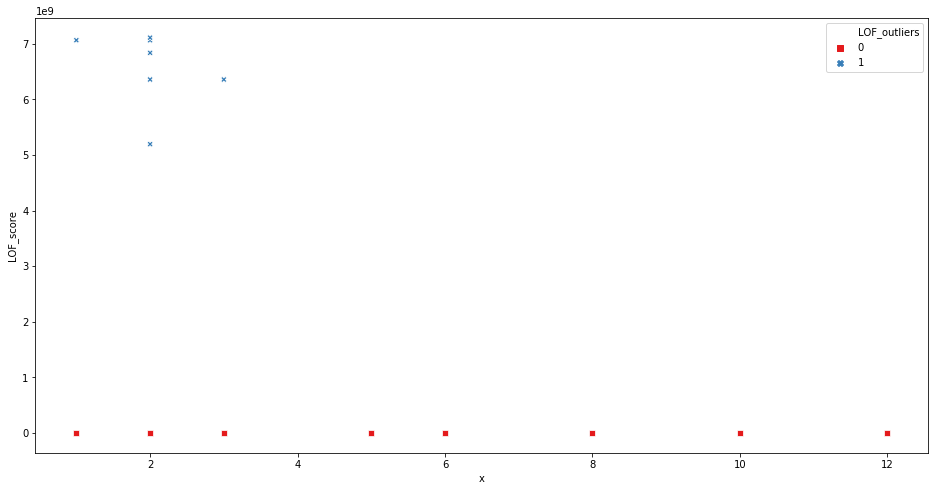

In [61]:
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
     x='x', 
    y='LOF_score', 
    #hue='is_outlier',
    hue='LOF_outliers',
    style='LOF_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values whoch are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

#### LOF on  Testset With Ground Truth labels

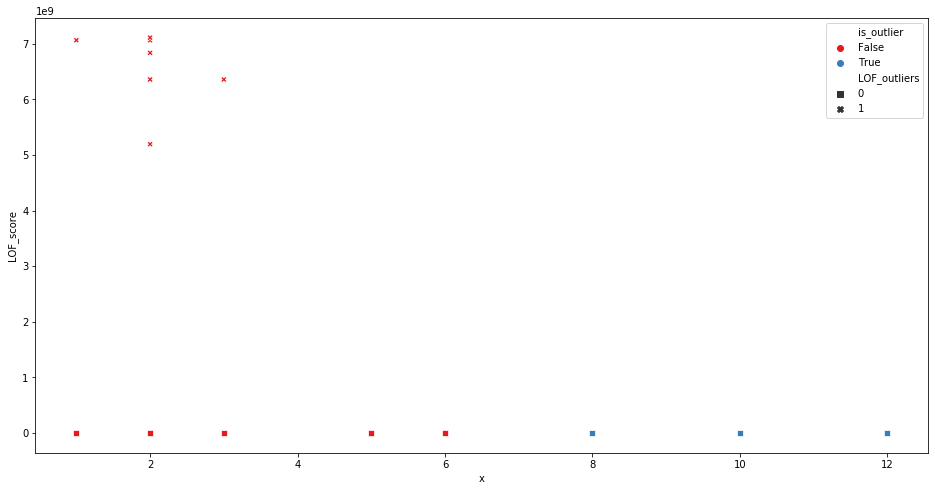

In [62]:
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
     x='x', 
    y='LOF_score', 
    hue='is_outlier',
    style='LOF_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values whoch are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

In [63]:



confusion_matrix(y_val, y_pred=df_test_plot.LOF_outliers )

y_pred=df_test_plot.LOF_outliers

#The F1 score: weighted average of the precision and recall, 
  #  where an F1 score reaches its best value at 1 and worst score at 0. 
  #  The relative contribution of precision and recall to the F1 score are equal.
    #F1 = 2 * (precision * recall) / (precision + recall)
print('f1_score ', f1_score(y_val, y_pred, average="macro"))


#The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
#fp the number of false positives.
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print('precision_score ',precision_score(y_val, y_pred, average="macro"))


#The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number 
#of false negatives.
#The recall is intuitively the ability of the classifier to find all the positive samples.
print('recall_score ',recall_score(y_val, y_pred, average="macro"))

f1_score  0.8535586277521762
precision_score  0.7777777777777778
recall_score  0.9928825622775801


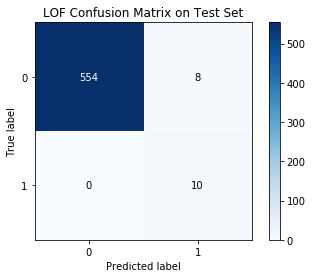

In [64]:
#Let’s plot the confusion matrix for the test set.

# plot the comfusion matrix  in the test set
skplt.metrics.plot_confusion_matrix(y_val,y_pred, normalize=False,
                                    title="LOF Confusion Matrix on Test Set")
plt.show()

## OCSVM

In [65]:

clf_ocsvm = OCSVM(kernel='rbf',  gamma='auto',nu=0.5,
                  contamination=0.1,tol=0.001, degree = 6,
                shrinking=True, cache_size=200,
                verbose=True, max_iter=-1)


            

In [66]:
clf_ocsvm 

OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=6, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=True)

In [67]:
%%time
clf_ocsvm.fit(X_train)#adjust the model to our trainset

df_train_plot['OCSVM_score'] = clf_ocsvm.decision_function(X_train)#calculate scores for the trainset
df_train_plot['OCSVM_outliers'] = clf_ocsvm.predict(X_train)#decide

df_train_plot



[LibSVM]Wall time: 52.1 ms


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers,LOF_score,LOF_outliers,OCSVM_score,OCSVM_outliers
timestamp,,,,,,,,,,
2019-06-06 09:43:21,1,False,-0.354012,0,0.0,0,1.0,0,0.000007,0
2019-06-24 06:29:17,1,False,-0.332515,0,0.0,0,1.0,0,0.000006,0
2019-06-24 20:02:12,1,False,-0.354012,0,0.0,0,1.0,0,0.000007,0
2019-06-24 20:46:40,1,False,-0.332515,0,0.0,0,1.0,0,0.000006,0
2019-06-25 20:02:09,1,False,-0.332515,0,0.0,0,1.0,0,0.000006,0
...,...,...,...,...,...,...,...,...,...,...
2020-03-05 21:49:47,1,False,-0.354012,0,0.0,0,1.0,0,0.000007,0
2020-03-05 21:49:48,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0
2020-03-05 21:49:49,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0


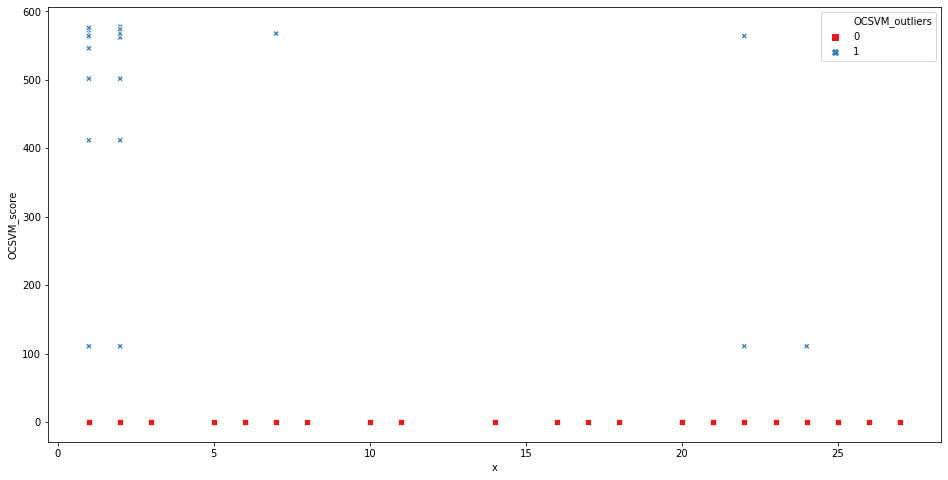

In [68]:
#scatterplot the results
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_train_plot, 
    x='x', 
    y='OCSVM_score', 
    hue='OCSVM_outliers',
    style='OCSVM_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

In [69]:
%%time
# get the prediction on the test data

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores =  clf_ocsvm.decision_function(X_test )  # outlier scores
#y_test_scores = pd.Series(y_test_scores)
y_test_pred =  clf_ocsvm.predict(X_test)
y_test_scores



df_test_plot['OCSVM_score'] = y_test_scores  
df_test_plot['OCSVM_outliers'] = y_test_pred 

df_test_plot

#df_test_plot['COF_outliers'].value_counts()

Wall time: 12 ms


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers,LOF_score,LOF_outliers,OCSVM_score,OCSVM_outliers
timestamp,,,,,,,,,,
2020-03-05 21:49:52,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0
2020-03-05 21:49:53,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0
2020-03-05 21:49:54,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0
2020-03-05 21:49:55,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0
2020-03-05 21:49:56,2,False,-0.354012,0,0.0,0,1.0,0,0.000007,0
...,...,...,...,...,...,...,...,...,...,...
2020-06-25 20:56:51,3,False,-0.332515,0,0.0,0,1.0,0,0.000006,0
2020-06-25 20:56:52,2,False,-0.354012,0,0.0,0,1.0,0,0.000007,0
2020-06-25 20:56:53,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0


#### OCSVM  on testset

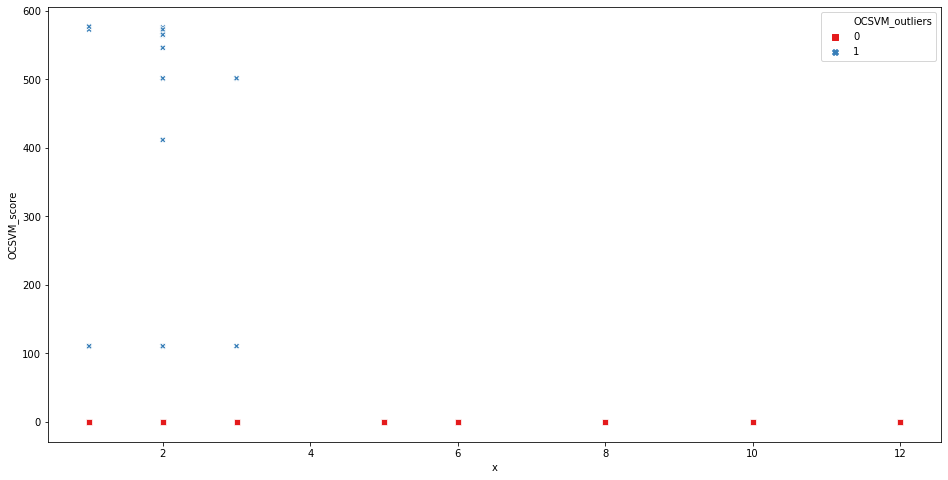

In [70]:
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='OCSVM_score', 
    hue='OCSVM_outliers',
   
    style='OCSVM_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

#### OCSVM on test set Avec Ground Truth labels

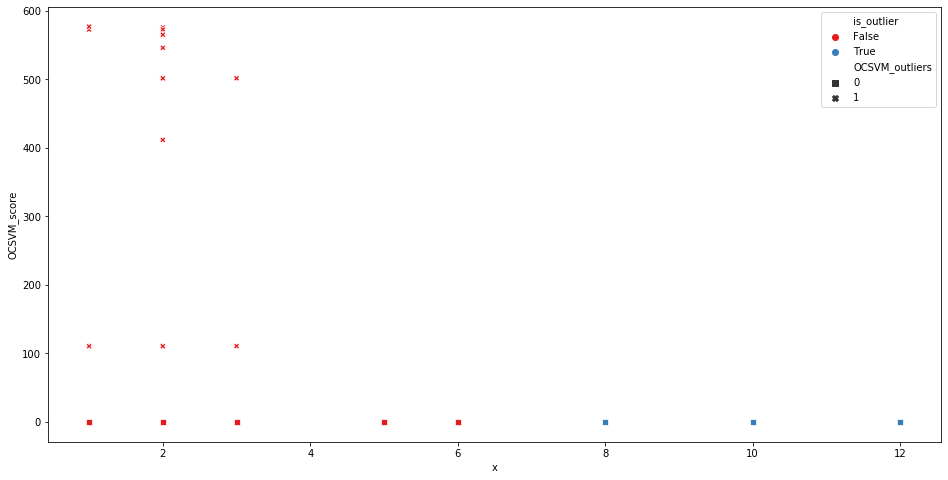

In [71]:
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='OCSVM_score', 
    hue='is_outlier',
    style='OCSVM_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

In [72]:
print("=df_test_plot.OCSVM_outliers ",df_test_plot.OCSVM_outliers )


=df_test_plot.OCSVM_outliers  timestamp
2020-03-05 21:49:52    0
2020-03-05 21:49:53    0
2020-03-05 21:49:54    0
2020-03-05 21:49:55    0
2020-03-05 21:49:56    0
                      ..
2020-06-25 20:56:51    0
2020-06-25 20:56:52    0
2020-06-25 20:56:53    0
2020-06-25 20:56:54    0
2020-06-25 20:56:55    0
Name: OCSVM_outliers, Length: 572, dtype: int32


In [73]:


y_pred=df_test_plot.OCSVM_outliers

#The F1 score: weighted average of the precision and recall, 
  #  where an F1 score reaches its best value at 1 and worst score at 0. 
  #  The relative contribution of precision and recall to the F1 score are equal.
    #F1 = 2 * (precision * recall) / (precision + recall)
print('f1_score ', f1_score(y_val, y_pred, average="macro"))


#The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
#fp the number of false positives.
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print('precision_score ',precision_score(y_val, y_pred, average="macro"))


#The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number 
#of false negatives.
#The recall is intuitively the ability of the classifier to find all the positive samples.
print('recall_score ',recall_score(y_val, y_pred, average="macro"))

f1_score  0.7108482458800931
precision_score  0.6428571428571428
recall_score  0.9777580071174377


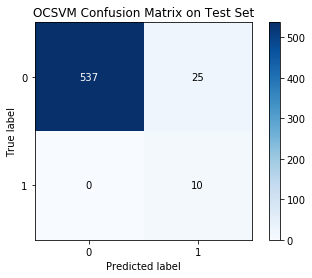

In [74]:
#Let’s plot the confusion matrix for the test set.

# plot the comfusion matrix  in the test set

skplt.metrics.plot_confusion_matrix(y_val,y_pred, normalize=False,
                                    title="OCSVM Confusion Matrix on Test Set")
plt.show()

## Connectivity-Based Outlier Factor (COF) Algorithm
Connectivity-Based Outlier Factor (COF) COF uses the ratio of average chaining distance of data point and the average of average chaining distance of k nearest neighbor of the data point, as the outlier score for observations.

In [75]:
clf_cof =COF(contamination=0.1, n_neighbors=20)


In [76]:
clf_cof

COF(contamination=0.1, n_neighbors=None)

In [77]:
%%time
clf_cof.fit(X_train)
#trainset score calculations and predictions
df_train_plot['COF_score'] = clf_cof.decision_function(X_train)
df_train_plot['COF_outliers'] = clf_cof.predict(X_train)

df_train_plot


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\pyod\models\cof.py:155: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(itemgetter(*sbn_path_index[_g])(ac_dist)))
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 8.11 s


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers,LOF_score,LOF_outliers,OCSVM_score,OCSVM_outliers,COF_score,COF_outliers
timestamp,,,,,,,,,,,,
2019-06-06 09:43:21,1,False,-0.354012,0,0.0,0,1.0,0,0.000007,0,0.0,0
2019-06-24 06:29:17,1,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
2019-06-24 20:02:12,1,False,-0.354012,0,0.0,0,1.0,0,0.000007,0,0.0,0
2019-06-24 20:46:40,1,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
2019-06-25 20:02:09,1,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-05 21:49:47,1,False,-0.354012,0,0.0,0,1.0,0,0.000007,0,0.0,0
2020-03-05 21:49:48,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
2020-03-05 21:49:49,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0


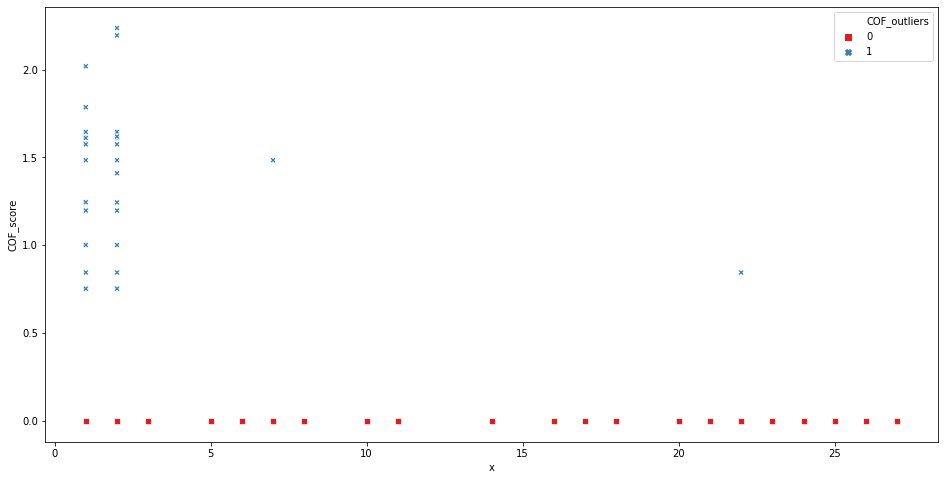

In [78]:
#plot the results on the trainset
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_train_plot, 
    x='x', 
    y='COF_score', 
   # hue='is_outlier',
    hue='COF_outliers',
    style='COF_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values whoch are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

In [79]:
%%time
# get the prediction on the test data

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores = clf_cof.decision_function(X_test )  # outlier scores
#y_test_scores = pd.Series(y_test_scores)
y_test_pred = clf_cof.predict(X_test)
y_test_scores


df_test_plot['COF_score'] = y_test_scores  
df_test_plot['COF_outliers'] = y_test_pred 

df_test_plot

#df_test_plot['COF_outliers'].value_counts()

C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\pyod\models\cof.py:155: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(itemgetter(*sbn_path_index[_g])(ac_dist)))


Wall time: 1.13 s


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers,LOF_score,LOF_outliers,OCSVM_score,OCSVM_outliers,COF_score,COF_outliers
timestamp,,,,,,,,,,,,
2020-03-05 21:49:52,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
2020-03-05 21:49:53,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
2020-03-05 21:49:54,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
2020-03-05 21:49:55,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
2020-03-05 21:49:56,2,False,-0.354012,0,0.0,0,1.0,0,0.000007,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25 20:56:51,3,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
2020-06-25 20:56:52,2,False,-0.354012,0,0.0,0,1.0,0,0.000007,0,0.0,0
2020-06-25 20:56:53,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0


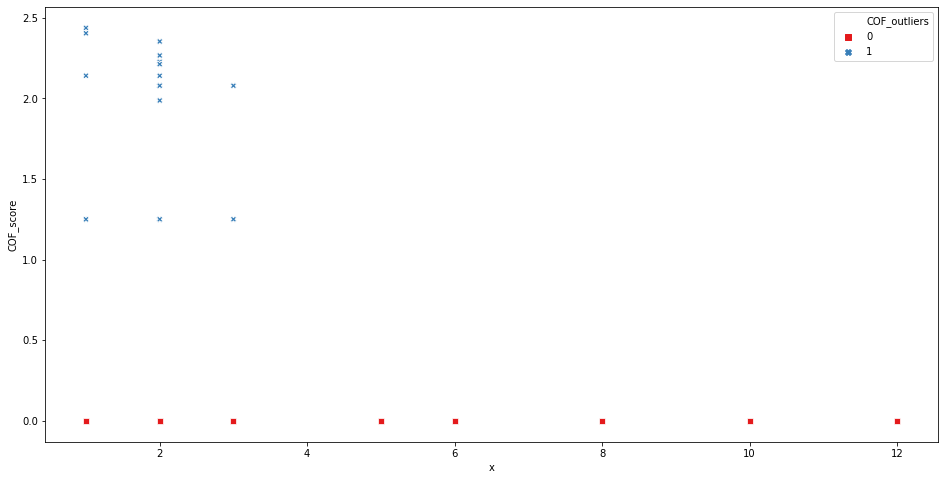

In [80]:
#plot the results on the testset
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='COF_score', 
    hue='COF_outliers',
    style='COF_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

#### COF on testset avec Ground truth labels

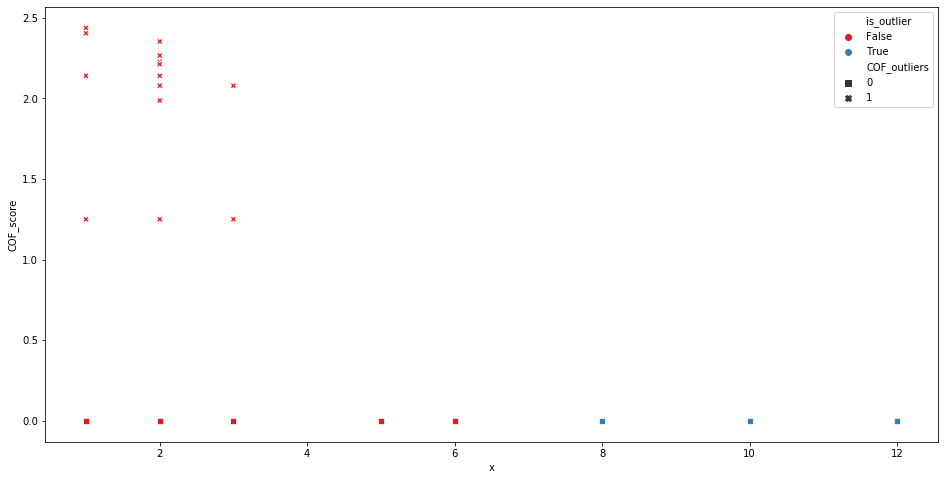

In [81]:
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='COF_score', 
    hue='is_outlier',
    style='COF_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values whoch are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

In [82]:


#y_true=y_test.astype(int)
y_pred=df_test_plot.COF_outliers

confusion_matrix(y_val, y_pred )

#The F1 score: weighted average of the precision and recall, 
  #  where an F1 score reaches its best value at 1 and worst score at 0. 
  #  The relative contribution of precision and recall to the F1 score are equal.
    #F1 = 2 * (precision * recall) / (precision + recall)
print('f1_score ', f1_score(y_val, y_pred, average="macro"))


#The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
#fp the number of false positives.
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print('precision_score ',precision_score(y_val, y_pred, average="macro"))


#The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number 
#of false negatives.
#The recall is intuitively the ability of the classifier to find all the positive samples.
print('recall_score ',recall_score(y_val, y_pred, average="macro"))

f1_score  0.7108482458800931
precision_score  0.6428571428571428
recall_score  0.9777580071174377


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\pyod\models\cof.py:155: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(itemgetter(*sbn_path_index[_g])(ac_dist)))


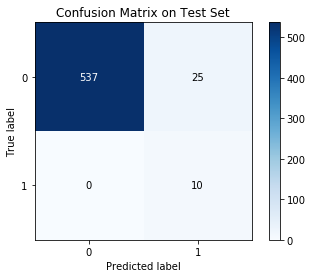

In [83]:
#Let’s plot the confusion matrix for the test set.

# plot the comfusion matrix  in the test set
y_preds = clf_cof.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test,y_preds, normalize=False,
                                    title="Confusion Matrix on Test Set")
plt.show()

## compare ML,models

In [84]:

df_test_plot.head()

,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers,LOF_score,LOF_outliers,OCSVM_score,OCSVM_outliers,COF_score,COF_outliers
timestamp,,,,,,,,,,,,
2020-03-05 21:49:52,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
2020-03-05 21:49:53,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
2020-03-05 21:49:54,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
2020-03-05 21:49:55,2,False,-0.332515,0,0.0,0,1.0,0,0.000006,0,0.0,0
2020-03-05 21:49:56,2,False,-0.354012,0,0.0,0,1.0,0,0.000007,0,0.0,0


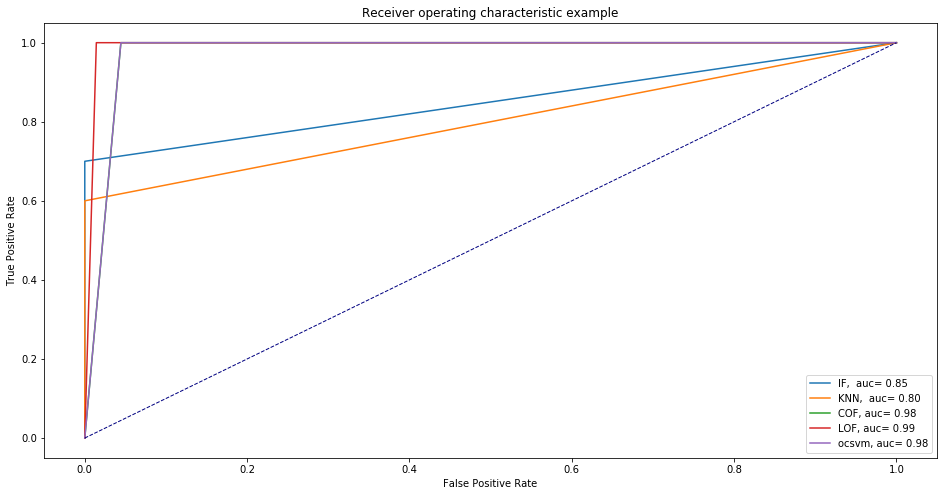

In [85]:
from sklearn import metrics

if_preds = df_test_plot['isolation_forest_outliers']
knn_preds = df_test_plot['KNN_outliers']
cof_preds = df_test_plot['COF_outliers']
lof_preds = df_test_plot['LOF_outliers']
ocsvm_preds = df_test_plot['OCSVM_outliers']


plt.figure(figsize=(16,8)).clf()

pred = if_preds
label = y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="IF,  auc= %0.2f" %(auc))

pred = knn_preds
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="KNN,  auc= %0.2f" %(auc))


pred = cof_preds
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="COF, auc= %0.2f" % (auc))

pred = lof_preds
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="LOF, auc= %0.2f"% (auc))

pred = ocsvm_preds

fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="ocsvm, auc= %0.2f"% (auc))

lw = 1
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")



On this graph, the y-axis is true positive rate, and the x-axis is false positive rate. 

Note the diagonal line - this is the baseline, that can be obtained with a random classifier. 
The further our ROC curve is above the line, the better